### test GTP

### 1) Use package as standalone

Test with single emission


| date | amount | flow | activity |
|-------|-------|------|----------|
| 15-12-2020   | 10    | 1 (CO2)   | 2        |


In [14]:
import pandas as pd
import numpy as np

# defining a dummy dynamic inventory from above
dynamic_inventory_df = pd.DataFrame(
        data={
            "date": pd.Series(
                data=[
                    "15-12-2020",
                    "20-12-2020",
                    #"25-05-2022",
                ],
                dtype="datetime64[s]",
            ),
            "amount": pd.Series(data=[1, 15], dtype="float64"),
            "flow": pd.Series(data=[2,1 ], dtype="int"),
            "activity": pd.Series(data=[2, 2], dtype="int"),
        }
    )

In [15]:
dynamic_inventory_df

,date,amount,flow,activity
0,2020-12-15,1.0,2,2
1,2020-12-20,15.0,1,2


In [16]:
from dynamic_characterization import characterize
from dynamic_characterization.ipcc_ar6 import characterize_co2, characterize_ch4

df_characterized = characterize(
        dynamic_inventory_df,
        metric="AGTP", # could also be GWP
        characterization_function_dict={
            1: characterize_co2,
            2: characterize_ch4,
        },
        time_horizon=100, #years
    )

In [17]:
df_characterized #[K]

,date,amount,flow,activity
0,2021-12-15 05:49:12,1.463861e-13,2,2
1,2021-12-20 05:49:12,1.881620e-14,1,2
2,2022-12-15 11:38:24,1.343458e-13,2,2
3,2022-12-20 11:38:24,1.764404e-14,1,2
4,2023-12-15 17:27:36,1.232954e-13,2,2
...,...,...,...,...
193,2117-12-20 12:32:24,2.155248e-15,1,2
194,2118-12-15 18:21:36,7.444210e-18,2,2
195,2118-12-20 18:21:36,1.515573e-15,1,2
196,2119-12-16 00:10:48,3.620084e-18,2,2


2.6811424701481627e-12

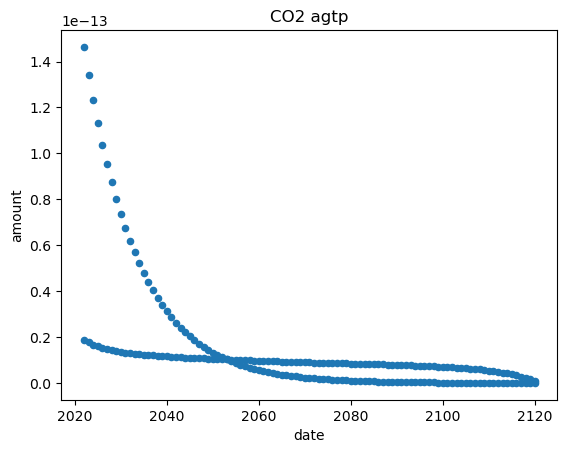

In [18]:
df_characterized.plot(x="date", y="amount", kind="scatter", title="CO2 agtp")
df_characterized["amount"].sum()  

In [19]:
df_characterized = characterize(
        dynamic_inventory_df,
        metric="GTP", 
        characterization_function_dict={
            1: characterize_co2,
            2: characterize_ch4,
        },
        time_horizon=100, #years
    )

df_characterized #[kg CO2-eq]

,date,amount,flow,activity
0,2020-12-15,29.517702,2,2
1,2020-12-20,15.000000,1,2
